Reading in stochastic data...,  0:00:00.000077
Reading in moea solutions...,  0:00:00.523031


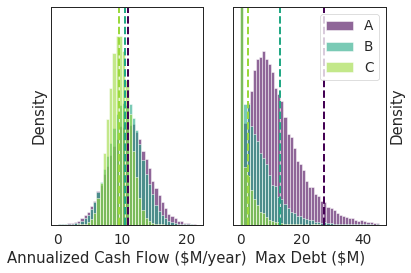

In [1]:
##############################################################################################################
### make_moea_output_plots.py - python script to create plots for multi-objective optimization outputs
### Project started May 2017, last update Jan 2020
##############################################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
import importlib
from datetime import datetime
import sys
sys.path.insert(1, 'code/synthetic_data_and_moea_plots/')
import warnings
warnings.filterwarnings('ignore')

### Project functions ###
import functions_moea_output_plots



sns.set_style('white')
sns.set_context('paper', font_scale=1.55)

eps = 1e-13
startTime = datetime.now()

dir_downloaded_inputs = './data/downloaded_inputs/'
dir_generated_inputs = './data/generated_inputs/'
dir_moea_output = './data/optimization_output/'
dir_figs = './figures/'





# ### get stochastic data
print('Reading in stochastic data..., ', datetime.now() - startTime)
synthetic_data = pd.read_csv(dir_generated_inputs + 'synthetic_data.txt', sep=' ')

### get historical simulation data
historical_simulation = pd.read_csv(dir_generated_inputs + 'historical_data.csv', index_col=0)

# ### constants
meanRevenue = np.mean(synthetic_data.revenue)
minSnowContract = 0.05
minMaxFund = 0.05
nYears=20
p_sfpuc = 150

### read in moea solutions for each LHC param sample
print('Reading in moea solutions..., ', datetime.now() - startTime)
importlib.reload(functions_moea_output_plots)
moea_solns_filtered = functions_moea_output_plots.get_moea_output(dir_generated_inputs, dir_moea_output, p_sfpuc,
                                                                  meanRevenue, minSnowContract, minMaxFund,
                                                                  debt_filter=True)
moea_solns_unfiltered = functions_moea_output_plots.get_moea_output(dir_generated_inputs, dir_moea_output, p_sfpuc,
                                                                    meanRevenue, minSnowContract, minMaxFund,
                                                                    debt_filter=False)

### choose 3 example policies for plotting from sfpuc baseline params
cases_sfpuc_index = [1591,1579,1595]
params_sfpuc = moea_solns_filtered.loc[moea_solns_filtered.p==p_sfpuc].iloc[0,:].loc[['Delta_debt','Delta_fund','c','delta','lam_capX_2','lam_capX_1',
                                                                                      'lam_capX_0','lam_capY_2','lam_capY_1','lam_capY_0','expected_net_revenue']]



### plot Pareto front for sfpuc baseline parameters (fig 8)
# print('Plotting Pareto set for baseline parameters... (fig 8), ', datetime.now() - startTime)
# index of 3 cases to highlight in plot [A = high cash flow, B = compromise, C = low debt]
# functions_moea_output_plots.plot_pareto_baseline(dir_figs, moea_solns_filtered, p_sfpuc, cases_sfpuc_index)



# ### plot simulated state variables for 3 example policies over historical period
# print('Plotting historical simulation for 3 policies, sfpuc baseline... (fig 8), ', datetime.now() - startTime)
# functions_moea_output_plots.plot_example_simulations(dir_figs, moea_solns_filtered, params_sfpuc, cases_sfpuc_index, historical_simulation, meanRevenue)


# ### plot histogram of objectives for 3 policies for sfpuc baseline parameters (fig 9). Will also compare python objectives (validate) to c++ version (borg, retest) to validate monte carlo model
# print('Plotting histogram of objectives for 3 policies, sfpuc baseline (fig 9)..., ', datetime.now() - startTime)
# # index of 3 cases to highlight in plot [A = high cash flow, B = compromise, C = low debt]
# importlib.reload(functions_moea_output_plots)
# functions_moea_output_plots.plot_distribution_objectives(dir_figs, synthetic_data, moea_solns_filtered, cases_sfpuc_index, params_sfpuc, meanRevenue, nYears)



In [12]:
def get_distribution_objectives(dir_figs, synthetic_data, moea_solns, cases_sfpuc_index, params_sfpuc, meanRevenue, nYears):

    fixedCostFraction = params_sfpuc['c']
    discountRate = 1 / (params_sfpuc['delta'] / 100 + 1)
    interestFund = (params_sfpuc['Delta_fund'] + params_sfpuc['delta']) / 100 + 1
    interestDebt = (params_sfpuc['Delta_debt'] + params_sfpuc['delta']) / 100 + 1
    cfdWtFeb = 0.311962707367
    cfdCapX = params_sfpuc['lam_capX_2'] * cfdWtFeb**2 + params_sfpuc['lam_capX_1'] * cfdWtFeb + params_sfpuc['lam_capX_0']
    cfdCapY = params_sfpuc['lam_capY_2'] * cfdWtFeb**2 + params_sfpuc['lam_capY_1'] * cfdWtFeb + params_sfpuc['lam_capY_0']
    synthetic_data['sweWt'] = cfdWtFeb * synthetic_data['sweFeb'] + (1 - cfdWtFeb) * synthetic_data['sweApr']

    cases_sfpuc_max_fund = moea_solns.max_fund.values[cases_sfpuc_index]
    cases_sfpuc_slope_cfd = moea_solns.slope_cfd.values[cases_sfpuc_index]
    cases_sfpuc_Jcash = moea_solns.exp_ann_cashflow_retest.values[cases_sfpuc_index]
    cases_sfpuc_Jdebt = moea_solns.q95_max_debt_retest.values[cases_sfpuc_index]

    # Run nSamples of nYears each and calculate objectives & constraint
    sample_starts = [0]
    objectivesA = functions_moea_output_plots.monte_carlo_objectives(synthetic_data, fixedCostFraction, meanRevenue,
                                     cases_sfpuc_max_fund[0], cases_sfpuc_slope_cfd[0], interestFund, interestDebt,
                                     discountRate, cfdCapX, cfdCapY, nYears, 50000, set_seed=6, full_output=True,
                                     sample_starts=sample_starts)
    objectivesB = functions_moea_output_plots.monte_carlo_objectives(synthetic_data, fixedCostFraction, meanRevenue,
                                     cases_sfpuc_max_fund[1], cases_sfpuc_slope_cfd[1], interestFund, interestDebt,
                                     discountRate, cfdCapX, cfdCapY, nYears, 50000, set_seed=6, full_output=True,
                                     sample_starts=sample_starts)
    objectivesC = functions_moea_output_plots.monte_carlo_objectives(synthetic_data, fixedCostFraction, meanRevenue,
                                     cases_sfpuc_max_fund[2], cases_sfpuc_slope_cfd[2], interestFund, interestDebt,
                                     discountRate, cfdCapX, cfdCapY, nYears, 50000, set_seed=6, full_output=True,
                                     sample_starts=sample_starts)

    return (objectivesA, objectivesB, objectivesC)

objectiveA, objectiveB, objectiveC = get_distribution_objectives(dir_figs, synthetic_data, moea_solns_filtered, cases_sfpuc_index, params_sfpuc, meanRevenue, nYears)

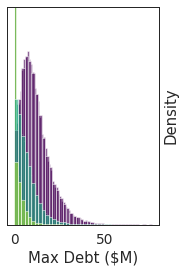

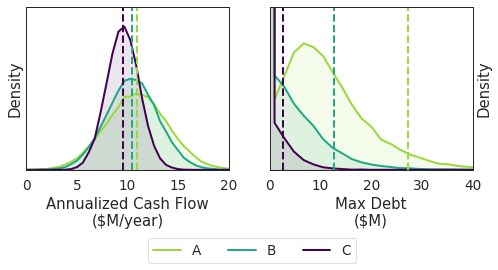

In [56]:
eps = 1e-13

cmap = cm.get_cmap('viridis')
col = [cmap(0),cmap(0.15),cmap(0.6),cmap(0.85)]
# col = [cmap(0.1),cmap(0.3),cmap(0.6),cmap(0.8)]

palette = {'None':col[0], 'Fund':col[3], 'CFD':col[1], 'Fund+CFD':col[2]}
marker = {'None':'<', 'Fund':'o', 'CFD':'*', 'Fund+CFD':'+', 'Infeasible':'$i$'}
alpha = {'None':0.7, 'Fund':0.7, 'CFD':0.7, 'Fund+CFD':0.7, 'Infeasible':0.0}

def plot_distribution_objectives(dir_figs, synthetic_data, moea_solns, cases_sfpuc_index, params_sfpuc, meanRevenue, nYears, objectivesA, objectivesB, objectivesC):

    fixedCostFraction = params_sfpuc['c']
    discountRate = 1 / (params_sfpuc['delta'] / 100 + 1)
    interestFund = (params_sfpuc['Delta_fund'] + params_sfpuc['delta']) / 100 + 1
    interestDebt = (params_sfpuc['Delta_debt'] + params_sfpuc['delta']) / 100 + 1
    cfdWtFeb = 0.311962707367
    cfdCapX = params_sfpuc['lam_capX_2'] * cfdWtFeb**2 + params_sfpuc['lam_capX_1'] * cfdWtFeb + params_sfpuc['lam_capX_0']
    cfdCapY = params_sfpuc['lam_capY_2'] * cfdWtFeb**2 + params_sfpuc['lam_capY_1'] * cfdWtFeb + params_sfpuc['lam_capY_0']
    synthetic_data['sweWt'] = cfdWtFeb * synthetic_data['sweFeb'] + (1 - cfdWtFeb) * synthetic_data['sweApr']

    cases_sfpuc_max_fund = moea_solns.max_fund.values[cases_sfpuc_index]
    cases_sfpuc_slope_cfd = moea_solns.slope_cfd.values[cases_sfpuc_index]
    cases_sfpuc_Jcash = moea_solns.exp_ann_cashflow_retest.values[cases_sfpuc_index]
    cases_sfpuc_Jdebt = moea_solns.q95_max_debt_retest.values[cases_sfpuc_index]

    maxxCash = max(max(objectivesA[::3]), max(objectivesB[::3]), max(objectivesC[::3]))
    nbins = 40
    bins = list(np.arange(0.01, maxxCash+0.05, (maxxCash+0.02)/nbins))
    bins.insert(0, -0.01)
    aCash = plt.hist(objectivesA[::3], bins=bins, density=True, alpha=0.6, color=col[0])#, bins=np.arange(0,44)/2)
    bCash = plt.hist(objectivesB[::3], bins=bins, density=True, alpha=0.6, color=col[2])#, bins=np.arange(0,44)/2)
    cCash = plt.hist(objectivesC[::3], bins=bins, density=True, alpha=0.6, color=col[3])#, bins=np.arange(0,44)/2)
    centersCash = (np.array(bins[:-1]) + np.array(bins[1:])) / 2

    ax = plt.subplot2grid((1,2), (0, 1))
    ax.set_xlabel('Max Debt ($M)')
    ax.set_ylabel('Density')
    ax.tick_params(axis='y', which='both', labelleft=False, labelright=False)
    ax.yaxis.set_label_position('right')
    ax.set_ylim([0, 0.07])

    plt.hist(objectivesA[1::3], density=True, alpha=0.6, color=col[0], bins=np.arange(0,46))
    plt.hist(objectivesB[1::3], density=True, alpha=0.6, color=col[2], bins=np.arange(0,46))
    plt.hist(objectivesC[1::3], density=True, alpha=0.6, color=col[3], bins=np.arange(0,46))
#     plt.legend(['A','B','C'], loc='upper right')

    maxxDebt = max(max(objectivesA[1::3]), max(objectivesB[1::3]), max(objectivesC[1::3]))
    nbins = 40
    bins = list(np.arange(0.01, maxxDebt+0.05, (maxxDebt+0.02)/nbins))
    bins.insert(0, -0.01)
    aDebt = plt.hist(objectivesA[1::3], bins=bins, density=True, alpha=0.6, color=col[0])#, bins=np.arange(0,44)/2)
    bDebt = plt.hist(objectivesB[1::3], bins=bins, density=True, alpha=0.6, color=col[2])#, bins=np.arange(0,44)/2)
    cDebt = plt.hist(objectivesC[1::3], bins=bins, density=True, alpha=0.6, color=col[3])#, bins=np.arange(0,44)/2)
    centersDebt = (np.array(bins[:-1]) + np.array(bins[1:])) / 2
    
#     plt.axvline(x=cases_sfpuc_Jdebt[0], color=col[0], linewidth=2, linestyle='--')
#     plt.axvline(x=cases_sfpuc_Jdebt[1], color=col[2], linewidth=2, linestyle='--')
#     plt.axvline(x=cases_sfpuc_Jdebt[2], color=col[3], linewidth=2, linestyle='--')

    
    
    plt.figure(figsize=(8,3))
    ax = plt.subplot2grid((1,2), (0, 0))
    ax.set_xlabel('Annualized Cash Flow\n($M/year)')
    ax.set_ylabel('Density')
    ax.tick_params(axis='y', which='both', labelleft=False, labelright=False)
    ax.set_ylim([0, 0.28])
    ax.set_xlim([0, 20])
    
    ax.plot(centersCash, aCash[0], color=col[3], linewidth=2)
    ax.plot(centersCash, bCash[0], color=col[2], linewidth=2)
    ax.plot(centersCash, cCash[0], color=col[0], linewidth=2)
    ax.fill_between(centersCash, aCash[0], color=col[3], alpha=0.1)
    ax.fill_between(centersCash, bCash[0], color=col[2], alpha=0.1)
    ax.fill_between(centersCash, cCash[0], color=col[0], alpha=0.1)
    ax.axvline(x=cases_sfpuc_Jcash[0], color=col[3], linewidth=2, linestyle='--')
    ax.axvline(x=cases_sfpuc_Jcash[1], color=col[2], linewidth=2, linestyle='--')
    ax.axvline(x=cases_sfpuc_Jcash[2], color=col[0], linewidth=2, linestyle='--')
#     ax.axvline(x=0, color='0.5', ls=':')
    ax.legend(['A','B','C'], loc='lower left', bbox_to_anchor=(0.6, -0.57), ncol=3, borderaxespad=0.)

    
    ax2 = plt.subplot2grid((1,2), (0, 1))
    ax2.set_xlabel('Max Debt\n($M)')
    ax2.set_ylabel('Density')
    ax2.tick_params(axis='y', which='both', labelleft=False, labelright=False)
    ax2.yaxis.set_label_position('right')
    ax2.set_ylim([0, 0.07])
    ax2.set_xlim([0, 40])

    
    ax2.plot(centersDebt, aDebt[0], color=col[3], linewidth=2)
    ax2.plot(centersDebt, bDebt[0], color=col[2], linewidth=2)
    ax2.plot(centersDebt, cDebt[0], color=col[0], linewidth=2)
    ax2.fill_between(centersDebt, aDebt[0], color=col[3], alpha=0.1)
    ax2.fill_between(centersDebt, bDebt[0], color=col[2], alpha=0.1)
    ax2.fill_between(centersDebt, cDebt[0], color=col[0], alpha=0.1)
    ax2.axvline(x=cases_sfpuc_Jdebt[0], color=col[3], linewidth=2, linestyle='--')
    ax2.axvline(x=cases_sfpuc_Jdebt[1], color=col[2], linewidth=2, linestyle='--')
    ax2.axvline(x=cases_sfpuc_Jdebt[2], color=col[0], linewidth=2, linestyle='--')
#     ax2.axvline(x=0, color='0.5', ls=':')

    plt.savefig(dir_figs + 'fig9.jpg', dpi=1200)

    return

plot_distribution_objectives(dir_figs, synthetic_data, moea_solns_filtered, cases_sfpuc_index, params_sfpuc, meanRevenue, nYears, objectiveA, objectiveB, objectiveC)